In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from code_vi.system import OpticsManager
from code_vi.elements import OpticalElement
from code_vi.ray_trace import RayTracer
from code_vi.visualization import Draw
from code_vi import optimization 

# 1. Initialize
manager = OpticsManager()

lens1 = OpticalElement(
    name="Lens 1", optic_type="Lens",
    x_center=12.7, y_center=245.0,   # Initial Guess
    orientation_angle=90.0,         
    clear_aperture=22.86, diameter=25.4, 
    center_thickness=2.4,           
    R1=np.inf, R2=-350.67,            
    k2=0, coeffs2=[], material="ZnSe"
)

lens2 = OpticalElement(
    name="Lens 2", optic_type="Lens",
    x_center=12.7, y_center=750.0,   # Initial Guess 
    orientation_angle=90.0,          
    clear_aperture=22.86, diameter=25.4, 
    center_thickness=2.4,           
    R1=350.67, R2=np.inf,            
    k1=0, coeffs1=[], material="ZnSe"
)

focal_plane_y = 1000.0               # Initial Guess
focal_plane_offset = 0.0

grating1 = OpticalElement(
    name="Grating 1", optic_type="Grating",
    x_center=12.7, y_center=focal_plane_y + focal_plane_offset, 
    orientation_angle=-90.0,   
    clear_aperture=45, diameter=50.8,
    groove_density=75.0, diffraction_order=-1, material="Gold"
)

grating2 = OpticalElement(
    name="Grating 2", optic_type="Grating",
    x_center=-10.0, y_center=(focal_plane_y - 25.0) + focal_plane_offset, 
    orientation_angle=0.0,   
    clear_aperture=45, diameter=50.8,
    groove_density=25.0, diffraction_order=1, material="Gold" 
)

manager.add_element(lens1)
manager.add_element(lens2)
manager.add_element(grating1)
manager.add_element(grating2)


Starting Lens 1 Optimization...
--- Optimizing Lens 1 for Collimation ---
--- Smart Source Generation (Target: Lens 1) ---
   Step 1: Finding valid grating length...
   -> Valid Grating Region: 12.00mm to 13.00mm (Extent: 1.00mm)
   Step 2: Optimizing angles for 1 sources...
     Src 1: X=12.0mm | Angles=[87.2°, 92.5°] (30 rays)
   Done. Generated 30 optimized rays.
--- Smart Source Generation (Target: Lens 1) ---
   Step 1: Finding valid grating length...
   -> Valid Grating Region: 12.00mm to 13.00mm (Extent: 1.00mm)
   Step 2: Optimizing angles for 1 sources...
     Src 1: X=12.0mm | Angles=[87.2°, 92.5°] (30 rays)
   Done. Generated 30 optimized rays.
--- Smart Source Generation (Target: Lens 1) ---
   Step 1: Finding valid grating length...
   -> Valid Grating Region: 12.00mm to 13.00mm (Extent: 1.00mm)
   Step 2: Optimizing angles for 1 sources...
     Src 1: X=12.0mm | Angles=[87.2°, 92.5°] (30 rays)
   Done. Generated 30 optimized rays.
--- Smart Source Generation (Target: Lens

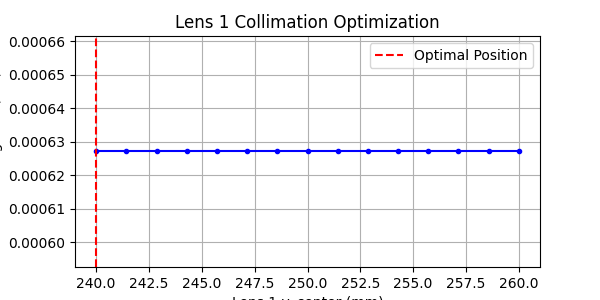


Starting Lens 2 Optimization...
--- Optimizing Lens 2 for Telecentric Spacing ---
--- Smart Source Generation (Target: Lens 2) ---
   Step 1: Finding valid grating length...
   -> Valid Grating Region: 1.34mm to 24.06mm (Extent: 22.73mm)
   Step 2: Optimizing angles for 3 sources...
     Src 1: X=1.3mm | Angles=[90.0°, 90.0°] (1 rays)
     Src 2: X=12.7mm | Angles=[87.4°, 92.5°] (20 rays)
     Src 3: X=24.1mm | Angles=[90.0°, 90.0°] (1 rays)
   Done. Generated 22 optimized rays.
--- Smart Source Generation (Target: Lens 2) ---
   Step 1: Finding valid grating length...
   -> Valid Grating Region: 1.34mm to 24.06mm (Extent: 22.73mm)
   Step 2: Optimizing angles for 3 sources...
     Src 1: X=1.3mm | Angles=[90.0°, 90.0°] (1 rays)
     Src 2: X=12.7mm | Angles=[87.4°, 92.5°] (20 rays)
     Src 3: X=24.1mm | Angles=[90.0°, 90.0°] (1 rays)
   Done. Generated 22 optimized rays.
--- Smart Source Generation (Target: Lens 2) ---
   Step 1: Finding valid grating length...
   -> Valid Grating R

KeyboardInterrupt: 

In [2]:
# 1. Optimize Lens 1 for Collimation
print("Starting Lens 1 Optimization...")
opt_L1_y = optimization.optimize_lens_collimation(
    manager, 
    lens_name="Lens 1", 
    guess_y=250.0, 
    search_window=10.0, 
    steps=15
)

# 2. Optimize Lens 2 for Perfect 4f Telecentricity 
print("\nStarting Lens 2 Optimization...")
opt_L2_y = optimization.optimize_telecentric_spacing(
    manager, 
    lens_name="Lens 2", 
    guess_y=opt_L1_y + 500.0,  # Start looking exactly 2f away from Lens 1
    search_window=10.0, 
    steps=15
)

# 3. Find the exact focal plane based on the true optimized lens layout
print("\nMapping the True Focal Plane...")
opt_focus_y = optimization.optimize_focal_plane(
    manager, 
    guess_y=opt_L2_y + 245.0, # Start looking roughly 1f past Lens 2
    search_window=15.0, 
    steps=20
)

print(f"\n✅ SYSTEM LOCKED.")
print(f"Lens 1 Final: {opt_L1_y:.3f} mm")
print(f"Lens 2 Final: {opt_L2_y:.3f} mm")
print(f"Focus Final:  {opt_focus_y:.3f} mm")

print("\n✅ OPTIMIZATION COMPLETE. OpticsManager is now locked and ready.")

In [ ]:
tracer = RayTracer(manager)

# --- SMART GENERATION ---
# This will now use the PERFECT optical layout to find the valid grating length!
tracer.generate_smart_spr_source(
    n_sources=11,               
    rays_per_source=20,         
    target_optic_name="Lens 2", 
    grating_search_bounds=(0, 25.4), 
    acceptance_angle_range=(70, 110), 
    grating_period=10.0,
    beam_energy=0.99
)    

print("Running High-Resolution Final Simulation...")
for t in np.arange(0, 5500, 50.0):
    tracer.run_time_step(t, 50.0)

tracer._sync_to_dataframe()

# Draw the final masterpiece
Draw.interactive_session(
    manager, 
    tracer, 
    show_curvature=False, 
    show_skeleton=True,       
    draw_beam_arrow=True,
    show_intersection_points=False
)